## Setting everything up

In [1]:
import os
#import iris
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
#import cartopy.crs as ccrs
import matplotlib.pyplot as plt
#from fbprophet import Prophet

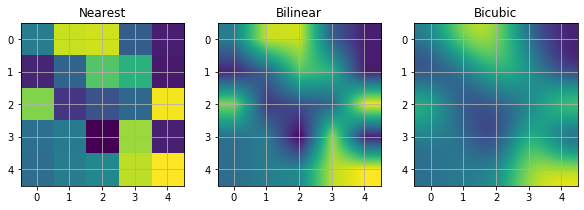

In [15]:
# test subplots combines
A = np.random.rand(5, 5)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for ax, interp in zip(axs, ['nearest', 'bilinear', 'bicubic']):
    ax.imshow(A, interpolation=interp)
    ax.set_title(interp.capitalize())
    ax.grid(True)

plt.show()

In [32]:
def test_plot(A,B,tit,ax=None):
    ax=ax
    plt.scatter(A,B)
    plt.ylabel('A')
    plt.xlabel('B')
    plt.title(tit)
    plt.show()

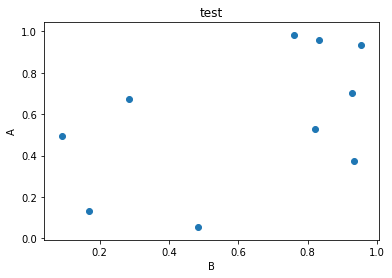

In [30]:
A=np.random.rand(10)
B=np.random.rand(10)
test_plot(A,B,'test')

In [26]:
def test_plot2(A,B,tit,ax1=None,ax2=None):
    ax1=ax1
    ax2=ax2
    ax1.plot(A,B)
    ax2.scatter(A,B)
    ax1.set_xlabel('A')
    ax1.axvline(x=0.5)
    ax1.set_xlim(0, 2)
    ax1.set_title(tit)
    ax2.set_xlabel('A')
    ax2.axvline(x=0.5)
    ax2.set_xlim(0, 2)
    ax2.set_title(tit)

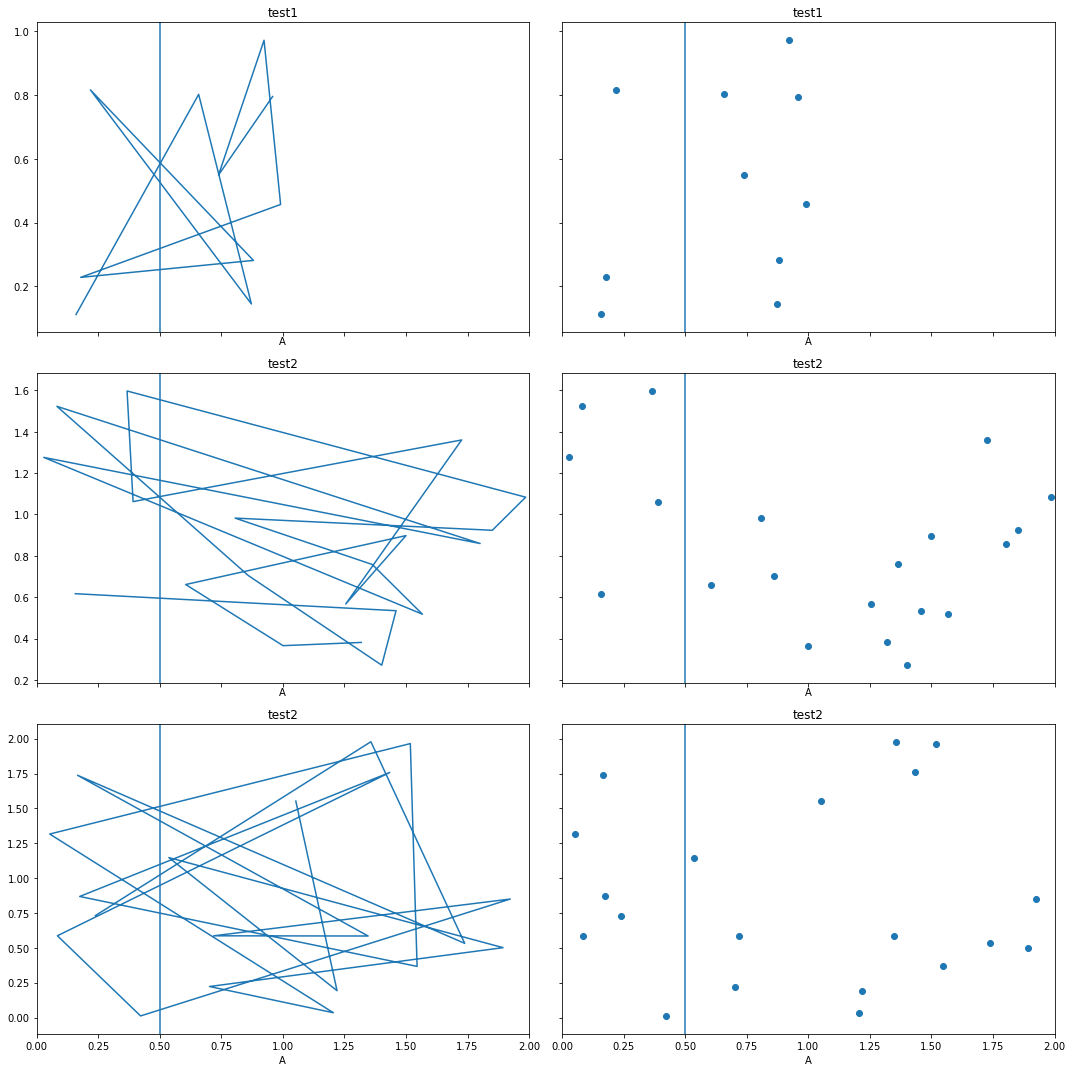

In [30]:
A1=np.random.rand(10)
B1=np.random.rand(10)
A2=np.random.rand(20)*2
B2=np.random.rand(20)*2
A3=np.random.rand(20)*2
B3=np.random.rand(20)*2
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,sharex='col', sharey='row',figsize=(15,15))
test_plot2(A1,B1,'test1',ax1,ax2)
test_plot2(A2,B2,'test2',ax3,ax4)
test_plot2(A3,B3,'test2',ax5,ax6)
fig.tight_layout()
plt.show()

## Functions for executions

### Phi-effective

In [2]:
## Basics
# sepearate into 5-yearly like Ivan's format, Dec-March 
def year_separator(year,month,ymin,ymax):
    return ((year < ymax) & (year > ymin)) | ((year == ymax) & (month <= 2)) | ((year == ymin) & (month >=12))

In [8]:
dataall.sel(time=slice('1950-12-01','1955-03-01'))

<xarray.Dataset>
Dimensions:       (lat: 280, lon: 1440, time: 450)
Coordinates:
  * time          (time) datetime64[ns] 1950-12-01 1950-12-02 ... 1955-02-28
  * lat           (lat) float32 20.25 20.5 20.75 21.0 ... 89.25 89.5 89.75 90.0
  * lon           (lon) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
Data variables:
    phi_eq_prime  (time, lat, lon) float32 nan nan nan ... 83.918 83.918 83.918

In [3]:
### Phi-Effective
#Reanalysis

def phi_eff_part1(lonsel,latsel):

    # read data
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1950_1979_eff_lat_demeaned_shifted.nc4')
    
    # 1950-1979
    dlist=[1950,1955,1960,1965,1970]
    smdf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
    sddf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
    skdf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
    for x in dlist:
        print(x)
        dataall.sel(time=slice(f'{x}-12-01',f'{x+5}-03-01'))
        select=data.sel(lon=lonsel,method='nearest')
        select=select.sel(lat=latsel,method='nearest')
        select=select.to_dataframe().reset_index()
        select['year']=select.time.dt.year
        select['month']=select.time.dt.month
        select=select.loc[select['month'].isin([1,2,12])]
        # assign by winter
        select['winter']=select['year']
        mask=select.month<=3
        select.loc[mask, 'winter'] = select['year']-1
        smyear=select.groupby(['winter'],as_index=False).mean().reset_index(drop=False)
        sdyear=select.groupby(['winter'],as_index=False).std().reset_index(drop=False)
        skyear=select.groupby(['winter'],as_index=False).skew().reset_index(drop=False)
        smdf=smdf.append(smyear, sort=True)
        sddf=sddf.append(sdyear, sort=True)
        skdf=skdf.append(skyear, sort=True)
    return smdf,sddf,skdf

In [4]:
# post-79
def phi_eff_part2(lonsel,latsel):
    
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1979_2021_eff_lat_demeaned_shifted.nc4')
    
    # 1979-2021
    dlist=[1980,1985,1990,1995,2000,2005,2010,2015]
    smdf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
    sddf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
    skdf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
    for x in dlist:
        print(x)
        data=dataall.sel(time=year_separator(dataall['time.year'],dataall['time.month'],x,x+5))
        select=data.sel(lon=lonsel,method='nearest')
        select=select.sel(lat=latsel,method='nearest')
        select=select.to_dataframe().reset_index()
        select['year']=select.time.dt.year
        select['month']=select.time.dt.month
        select=select.loc[(select['month'] == 1) | (select['month'] == 2) | (select['month'] == 12)]
        # assign by winter
        select['winter']=select['year']
        mask=select.month<=3
        select.loc[mask, 'winter'] = select['year']-1
        smyear=select.groupby(['winter']).mean().reset_index(drop=False)
        sdyear=select.groupby(['winter']).std().reset_index(drop=False)
        skyear=select.groupby(['winter']).skew().reset_index(drop=False)
        smdf=smdf.append(smyear, sort=True)
        sddf=sddf.append(sdyear, sort=True)
        skdf=skdf.append(skyear, sort=True)
    return smdf,sddf,skdf

In [5]:
# models
# Compile and loop around different models
def phi_eff_models(lonsel,latsel):
    flist=['CESM2','MPI','GFDL','IPSL']
    lp=1
    for z in flist:
        
        # read data
        dataall=xr.load_dataset('/project2/moyer/jetstream/cmip6_processed_data/post_processing_output/'+z+'_eff_lat_demeaned_shifted.nc4')
        
        # drop year 2100 with all zeros 
        dataall=dataall.sel(time=(dataall['time.year']!=2100))
    
        # select Chicago and compute standard deviation and skewness by 5-year, appending them all together
        dlist=[2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095]
        smdf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
        sddf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
        skdf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
        for x in dlist:
            print(x)
            # read into the 5-year interval
            data=dataall.sel(time=year_separator(dataall['time.year'],dataall['time.month'],x,x+5))
            select=data.sel(lon=lonsel,method='nearest')
            select=select.sel(lat=lat_closest_value)
            select=select.to_dataframe().reset_index()
            select['year']=select.time.dt.year
            select['month']=select.time.dt.month
            select=select.loc[(select['month'] == 1) | (select['month'] == 2) | (select['month'] == 12)]
            # assign by winter
            select['winter']=select['year']
            mask=select.month<=3
            select.loc[mask, 'winter'] = select['year']-1
            smyear=select.groupby(['winter']).mean().reset_index(drop=False)
            sdyear=select.groupby(['winter']).std().reset_index(drop=False)
            skyear=select.groupby(['winter']).skew().reset_index(drop=False)
            smdf=smdf.append(smyear, sort=True)
            sddf=sddf.append(sdyear, sort=True)
            skdf=skdf.append(skyear, sort=True)
          
        # output as individual datasets
        globals()['smdf%s' % lp] = smdf
        globals()['sddf%s' % lp] = sddf
        globals()['skdf%s' % lp] = skdf
        lp=lp+1
        
    # return
    return smdf1,sddf1,skdf1,smdf2,sddf2,skdf2,smdf3,sddf3,skdf3,smdf4,sddf4,skdf4

In [6]:
## outputing the files summarized and raw
def phi_eff_output(lonsel,latsel,city):
    
    smdf_pre1,sddf_pre1,skdf_pre1=phi_eff_part1(lonsel,latsel)
    smdf_pre1['decade']=(np.floor((smdf_pre1['winter']-1950)/5)+1)*5+1945
    smsum_pre1=smdf_pre1[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sddf_pre1['decade']=(np.floor((sddf_pre1['winter']-1950)/5)+1)*5+1945
    sdsum_pre1=sddf_pre1[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    skdf_pre1['decade']=(np.floor((skdf_pre1['winter']-1950)/5)+1)*5+1945
    sksum_pre1=skdf_pre1[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    smsum_pre1.columns=smsum_pre1.columns.droplevel()
    smsum_pre1=smsum_pre1.reset_index()
    sdsum_pre1.columns=sdsum_pre1.columns.droplevel()
    sdsum_pre1=sdsum_pre1.reset_index()
    sksum_pre1.columns=sksum_pre1.columns.droplevel()
    sksum_pre1=sksum_pre1.reset_index()
    
    smdf_pre2,sddf_pre2,skdf_pre2=phi_eff_part2(lonsel,latsel)
    smdf_pre2['decade']=(np.floor((smdf_pre2['winter']-1980)/5)+1)*5+1975
    smsum_pre2=smdf_pre2[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sddf_pre2['decade']=(np.floor((sddf_pre2['winter']-1980)/5)+1)*5+1975
    sdsum_pre2=sddf_pre2[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    skdf_pre2['decade']=(np.floor((skdf_pre2['winter']-1980)/5)+1)*5+1975
    sksum_pre2=skdf_pre2[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    smsum_pre2.columns=smsum_pre2.columns.droplevel()
    smsum_pre2=smsum_pre2.reset_index()
    sdsum_pre2.columns=sdsum_pre2.columns.droplevel()
    sdsum_pre2=sdsum_pre2.reset_index()
    sksum_pre2.columns=sksum_pre2.columns.droplevel()
    sksum_pre2=sksum_pre2.reset_index()
    
    smdf1,sddf1,skdf1,smdf2,sddf2,skdf2,smdf3,sddf3,skdf3,smdf4,sddf4,skdf4=phi_eff_models(lonsel,latsel)
    smdf1['decade']=(np.floor((smdf1['winter']-2015)/5)+1)*5+2010
    smdf2['decade']=(np.floor((smdf2['winter']-2015)/5)+1)*5+2010
    smdf3['decade']=(np.floor((smdf3['winter']-2015)/5)+1)*5+2010
    smdf4['decade']=(np.floor((smdf4['winter']-2015)/5)+1)*5+2010
    sddf1['decade']=(np.floor((sddf1['winter']-2015)/5)+1)*5+2010
    sddf2['decade']=(np.floor((sddf2['winter']-2015)/5)+1)*5+2010
    sddf3['decade']=(np.floor((sddf3['winter']-2015)/5)+1)*5+2010
    sddf4['decade']=(np.floor((sddf4['winter']-2015)/5)+1)*5+2010
    skdf1['decade']=(np.floor((skdf1['winter']-2015)/5)+1)*5+2010
    skdf2['decade']=(np.floor((skdf2['winter']-2015)/5)+1)*5+2010
    skdf3['decade']=(np.floor((skdf3['winter']-2015)/5)+1)*5+2010
    skdf4['decade']=(np.floor((skdf4['winter']-2015)/5)+1)*5+2010

    smsum1=smdf1[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    smsum2=smdf2[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    smsum3=smdf3[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    smsum4=smdf4[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum1=sddf1[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum2=sddf2[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum3=sddf3[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum4=sddf4[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum1=skdf1[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum2=skdf2[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum3=skdf3[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum4=skdf4[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    
    smsum1.columns=smsum1.columns.droplevel()
    smsum1=smsum1.reset_index()
    smsum2.columns=smsum2.columns.droplevel()
    smsum2=smsum2.reset_index()
    smsum3.columns=smsum3.columns.droplevel()
    smsum3=smsum3.reset_index()
    smsum4.columns=smsum4.columns.droplevel()
    smsum4=smsum4.reset_index()

    sdsum1.columns=sdsum1.columns.droplevel()
    sdsum1=sdsum1.reset_index()
    sdsum2.columns=sdsum2.columns.droplevel()
    sdsum2=sdsum2.reset_index()
    sdsum3.columns=sdsum3.columns.droplevel()
    sdsum3=sdsum3.reset_index()
    sdsum4.columns=sdsum4.columns.droplevel()
    sdsum4=sdsum4.reset_index()
    
    sksum1.columns=sksum1.columns.droplevel()
    sksum1=sksum1.reset_index()
    sksum2.columns=sksum2.columns.droplevel()
    sksum2=sksum2.reset_index()
    sksum3.columns=sksum3.columns.droplevel()
    sksum3=sksum3.reset_index()
    sksum4.columns=sksum4.columns.droplevel()
    sksum4=sksum4.reset_index()

    smdf_pre1.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smdf_pre1.csv',index=True)
    smdf_pre2.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smdf_pre2.csv',index=True)
    smdf1.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smdf1.csv',index=True)
    smdf2.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smdf2.csv',index=True)
    smdf3.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smdf3.csv',index=True)
    smdf4.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smdf4.csv',index=True)
    smsum_pre1.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smsum_pre1.csv',index=True)
    smsum_pre2.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smsum_pre2.csv',index=True)
    smsum1.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smsum1.csv',index=True)
    smsum2.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smsum2.csv',index=True)
    smsum3.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smsum3.csv',index=True)
    smsum4.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smsum4.csv',index=True)
    
    sddf_pre1.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sddf_pre1.csv',index=True)
    sddf_pre2.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sddf_pre2.csv',index=True)
    sddf1.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sddf1.csv',index=True)
    sddf2.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sddf2.csv',index=True)
    sddf3.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sddf3.csv',index=True)
    sddf4.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sddf4.csv',index=True)
    sdsum_pre1.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sdsum_pre1.csv',index=True)
    sdsum_pre2.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sdsum_pre2.csv',index=True)
    sdsum1.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sdsum1.csv',index=True)
    sdsum2.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sdsum2.csv',index=True)
    sdsum3.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sdsum3.csv',index=True)
    sdsum4.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sdsum4.csv',index=True)
    
    skdf_pre1.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_skdf_pre1.csv',index=True)
    skdf_pre2.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_skdf_pre2.csv',index=True)
    skdf1.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_skdf1.csv',index=True)
    skdf2.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_skdf2.csv',index=True)
    skdf3.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_skdf3.csv',index=True)
    skdf4.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_skdf4.csv',index=True)
    sksum_pre1.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sksum_pre1.csv',index=True)
    sksum_pre2.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sksum_pre2.csv',index=True)
    sksum1.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sksum1.csv',index=True)
    sksum2.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sksum2.csv',index=True)
    sksum3.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sksum3.csv',index=True)
    sksum4.to_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sksum4.csv',index=True)
    

In [7]:
# Chicago
phi_eff_output(-87.5,42,'Chicago')

closest value
42.0
-87.5
1950
1955
1960
1965
1970
closest value
42.0
-87.5
1980
1985
1990
1995
2000
2005
2010
2015
CESM2
closest value
41.93717277486911
-87.5
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
MPI
closest value
41.61021795745573
-87.1875
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
GFDL
closest value
41.5
-88.125
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
IPSL
closest value
41.83098602294922
-87.5
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095


### Demean T-prime

In [8]:
#Reanalysis

def dm_t_prime_part1(lonsel,latsel):
    print('closest value')
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1950_1979_t_prime_demeaned.nc4')
    given_value=latsel
    lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
    print(lat_closest_value)
    given_value=lonsel
    lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
    print(lon_closest_value)

    # 1950-1979
    dlist=[1950,1955,1960,1965,1970]
    smdf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
    sddf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
    skdf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
    for x in dlist:
        print(x)
        data=dataall.sel(time=year_separator(dataall['time.year'],dataall['time.month'],x,x+5))
        select=data.sel(lon=lon_closest_value)
        select=select.sel(lat=lat_closest_value)
        select=select.to_dataframe().reset_index()
        select['year']=select.time.dt.year
        select['month']=select.time.dt.month
        select=select.loc[(select['month'] == 1) | (select['month'] == 2) | (select['month'] == 12)]
        # assign by winter
        select['winter']=select['year']
        mask=select.month<=3
        select.loc[mask, 'winter'] = select['year']-1
        smyear=select.groupby(['winter']).mean().reset_index(drop=False)
        sdyear=select.groupby(['winter']).std().reset_index(drop=False)
        skyear=select.groupby(['winter']).skew().reset_index(drop=False)
        smdf=smdf.append(smyear, sort=True)
        sddf=sddf.append(sdyear, sort=True)
        skdf=skdf.append(skyear, sort=True)
    return smdf,sddf,skdf

In [9]:
# post-79
def dm_t_prime_part2(lonsel,latsel):
    print('closest value')
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1979_2021_t_prime_demeaned.nc4')
    given_value=latsel
    lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
    print(lat_closest_value)
    given_value=lonsel
    lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
    print(lon_closest_value)

    # 1979-2021
    dlist=[1980,1985,1990,1995,2000,2005,2010,2015]
    smdf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
    sddf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
    skdf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
    for x in dlist:
        print(x)
        data=dataall.sel(time=year_separator(dataall['time.year'],dataall['time.month'],x,x+5))
        select=data.sel(lon=lon_closest_value)
        select=select.sel(lat=lat_closest_value)
        select=select.to_dataframe().reset_index()
        select['year']=select.time.dt.year
        select['month']=select.time.dt.month
        select=select.loc[(select['month'] == 1) | (select['month'] == 2) | (select['month'] == 12)]
        # assign by winter
        select['winter']=select['year']
        mask=select.month<=3
        select.loc[mask, 'winter'] = select['year']-1
        smyear=select.groupby(['winter']).mean().reset_index(drop=False)
        sdyear=select.groupby(['winter']).std().reset_index(drop=False)
        skyear=select.groupby(['winter']).skew().reset_index(drop=False)
        smdf=smdf.append(smyear, sort=True)
        sddf=sddf.append(sdyear, sort=True)
        skdf=skdf.append(skyear, sort=True)
    return smdf,sddf,skdf

In [10]:
# models
# Compile and loop around different models
def dm_t_prime_models(lonsel,latsel):
    flist=['CESM2','MPI','GFDL','IPSL']
    lp=1
    for z in flist:
        print(z)
        print('closest value')
        # closest value definition
        dataall=xr.load_dataset('/project2/moyer/jetstream/cmip6_processed_data/post_processing_output/'+z+'_t_prime_demeaned.nc4')
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        given_value=latsel
        lat_closest_value = min(dataall.to_dataframe().reset_index().lat.unique(), key=absolute_difference_function)
        print(lat_closest_value)
        given_value=lonsel
        lon_closest_value = min(dataall.to_dataframe().reset_index().lon.unique(), key=absolute_difference_function)
        print(lon_closest_value)
        
        # drop year 2100 with all zeros 
        dataall=dataall.sel(time=(dataall['time.year']!=2100))
    
        # select Chicago and compute standard deviation and skewness by 5-year, appending them all together
        dlist=[2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095]
        smdf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
        sddf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
        skdf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
        for x in dlist:
            print(x)
            # read into the 5-year interval
            data=dataall.sel(time=year_separator(dataall['time.year'],dataall['time.month'],x,x+5))
            select=data.sel(lon=lon_closest_value)
            select=select.sel(lat=lat_closest_value)
            select=select.to_dataframe().reset_index()
            select['year']=select.time.dt.year
            select['month']=select.time.dt.month
            select=select.loc[(select['month'] == 1) | (select['month'] == 2) | (select['month'] == 12)]
            # assign by winter
            select['winter']=select['year']
            mask=select.month<=3
            select.loc[mask, 'winter'] = select['year']-1
            smyear=select.groupby(['winter']).mean().reset_index(drop=False)
            sdyear=select.groupby(['winter']).std().reset_index(drop=False)
            skyear=select.groupby(['winter']).skew().reset_index(drop=False)
            smdf=smdf.append(smyear, sort=True)
            sddf=sddf.append(sdyear, sort=True)
            skdf=skdf.append(skyear, sort=True)
          
        # output as individual datasets
        globals()['smdf%s' % lp] = smdf
        globals()['sddf%s' % lp] = sddf
        globals()['skdf%s' % lp] = skdf
        lp=lp+1
        
    # return
    return smdf1,sddf1,skdf1,smdf2,sddf2,skdf2,smdf3,sddf3,skdf3,smdf4,sddf4,skdf4

In [11]:
## outputing
def dm_t_prime_output(lonsel,latsel,city):
    
    smdf_pre1,sddf_pre1,skdf_pre1=dm_t_prime_part1(lonsel,latsel)
    smdf_pre1['decade']=(np.floor((smdf_pre1['winter']-1950)/5)+1)*5+1945
    smsum_pre1=smdf_pre1[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sddf_pre1['decade']=(np.floor((sddf_pre1['winter']-1950)/5)+1)*5+1945
    sdsum_pre1=sddf_pre1[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    skdf_pre1['decade']=(np.floor((skdf_pre1['winter']-1950)/5)+1)*5+1945
    sksum_pre1=skdf_pre1[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    smsum_pre1.columns=smsum_pre1.columns.droplevel()
    smsum_pre1=smsum_pre1.reset_index()
    sdsum_pre1.columns=sdsum_pre1.columns.droplevel()
    sdsum_pre1=sdsum_pre1.reset_index()
    sksum_pre1.columns=sksum_pre1.columns.droplevel()
    sksum_pre1=sksum_pre1.reset_index()
    
    smdf_pre2,sddf_pre2,skdf_pre2=dm_t_prime_part2(lonsel,latsel)
    smdf_pre2['decade']=(np.floor((smdf_pre2['winter']-1980)/5)+1)*5+1975
    smsum_pre2=smdf_pre2[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sddf_pre2['decade']=(np.floor((sddf_pre2['winter']-1980)/5)+1)*5+1975
    sdsum_pre2=sddf_pre2[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    skdf_pre2['decade']=(np.floor((skdf_pre2['winter']-1980)/5)+1)*5+1975
    sksum_pre2=skdf_pre2[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    smsum_pre2.columns=smsum_pre2.columns.droplevel()
    smsum_pre2=smsum_pre2.reset_index()
    sdsum_pre2.columns=sdsum_pre2.columns.droplevel()
    sdsum_pre2=sdsum_pre2.reset_index()
    sksum_pre2.columns=sksum_pre2.columns.droplevel()
    sksum_pre2=sksum_pre2.reset_index()
    
    smdf1,sddf1,skdf1,smdf2,sddf2,skdf2,smdf3,sddf3,skdf3,smdf4,sddf4,skdf4=dm_t_prime_models(lonsel,latsel)
    smdf1['decade']=(np.floor((smdf1['winter']-2015)/5)+1)*5+2010
    smdf2['decade']=(np.floor((smdf2['winter']-2015)/5)+1)*5+2010
    smdf3['decade']=(np.floor((smdf3['winter']-2015)/5)+1)*5+2010
    smdf4['decade']=(np.floor((smdf4['winter']-2015)/5)+1)*5+2010
    sddf1['decade']=(np.floor((sddf1['winter']-2015)/5)+1)*5+2010
    sddf2['decade']=(np.floor((sddf2['winter']-2015)/5)+1)*5+2010
    sddf3['decade']=(np.floor((sddf3['winter']-2015)/5)+1)*5+2010
    sddf4['decade']=(np.floor((sddf4['winter']-2015)/5)+1)*5+2010
    skdf1['decade']=(np.floor((skdf1['winter']-2015)/5)+1)*5+2010
    skdf2['decade']=(np.floor((skdf2['winter']-2015)/5)+1)*5+2010
    skdf3['decade']=(np.floor((skdf3['winter']-2015)/5)+1)*5+2010
    skdf4['decade']=(np.floor((skdf4['winter']-2015)/5)+1)*5+2010

    smsum1=smdf1[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    smsum2=smdf2[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    smsum3=smdf3[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    smsum4=smdf4[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum1=sddf1[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum2=sddf2[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum3=sddf3[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum4=sddf4[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum1=skdf1[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum2=skdf2[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum3=skdf3[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum4=skdf4[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    
    smsum1.columns=smsum1.columns.droplevel()
    smsum1=smsum1.reset_index()
    smsum2.columns=smsum2.columns.droplevel()
    smsum2=smsum2.reset_index()
    smsum3.columns=smsum3.columns.droplevel()
    smsum3=smsum3.reset_index()
    smsum4.columns=smsum4.columns.droplevel()
    smsum4=smsum4.reset_index()

    sdsum1.columns=sdsum1.columns.droplevel()
    sdsum1=sdsum1.reset_index()
    sdsum2.columns=sdsum2.columns.droplevel()
    sdsum2=sdsum2.reset_index()
    sdsum3.columns=sdsum3.columns.droplevel()
    sdsum3=sdsum3.reset_index()
    sdsum4.columns=sdsum4.columns.droplevel()
    sdsum4=sdsum4.reset_index()
    
    sksum1.columns=sksum1.columns.droplevel()
    sksum1=sksum1.reset_index()
    sksum2.columns=sksum2.columns.droplevel()
    sksum2=sksum2.reset_index()
    sksum3.columns=sksum3.columns.droplevel()
    sksum3=sksum3.reset_index()
    sksum4.columns=sksum4.columns.droplevel()
    sksum4=sksum4.reset_index()

    smdf_pre1.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smdf_pre1.csv',index=True)
    smdf_pre2.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smdf_pre2.csv',index=True)
    smdf1.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smdf1.csv',index=True)
    smdf2.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smdf2.csv',index=True)
    smdf3.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smdf3.csv',index=True)
    smdf4.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smdf4.csv',index=True)
    smsum_pre1.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smsum_pre1.csv',index=True)
    smsum_pre2.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smsum_pre2.csv',index=True)
    smsum1.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smsum1.csv',index=True)
    smsum2.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smsum2.csv',index=True)
    smsum3.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smsum3.csv',index=True)
    smsum4.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smsum4.csv',index=True)
    
    sddf_pre1.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sddf_pre1.csv',index=True)
    sddf_pre2.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sddf_pre2.csv',index=True)
    sddf1.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sddf1.csv',index=True)
    sddf2.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sddf2.csv',index=True)
    sddf3.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sddf3.csv',index=True)
    sddf4.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sddf4.csv',index=True)
    sdsum_pre1.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sdsum_pre1.csv',index=True)
    sdsum_pre2.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sdsum_pre2.csv',index=True)
    sdsum1.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sdsum1.csv',index=True)
    sdsum2.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sdsum2.csv',index=True)
    sdsum3.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sdsum3.csv',index=True)
    sdsum4.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sdsum4.csv',index=True)
    
    skdf_pre1.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_skdf_pre1.csv',index=True)
    skdf_pre2.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_skdf_pre2.csv',index=True)
    skdf1.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_skdf1.csv',index=True)
    skdf2.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_skdf2.csv',index=True)
    skdf3.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_skdf3.csv',index=True)
    skdf4.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_skdf4.csv',index=True)
    sksum_pre1.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sksum_pre1.csv',index=True)
    sksum_pre2.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sksum_pre2.csv',index=True)
    sksum1.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sksum1.csv',index=True)
    sksum2.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sksum2.csv',index=True)
    sksum3.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sksum3.csv',index=True)
    sksum4.to_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sksum4.csv',index=True)


In [12]:
# Chicago
dm_t_prime_output(-87.5,42,'Chicago')

closest value
42.0
-87.5
1950
1955
1960
1965
1970
closest value
42.0
-87.5
1980
1985
1990
1995
2000
2005
2010
2015
CESM2
closest value
41.93717277486911
-87.5
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
MPI
closest value
41.61021795745573
-87.1875
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
GFDL
closest value
41.5
-88.125
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
IPSL
closest value
41.83098602294922
-87.5
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095


In [13]:
ls -l /project2/moyer/jetstream/ribbon_files

total 768
-rw-rw-r-- 1 yuqisong pi-moyer 6473 Jun 18 14:15 dm_t_prime_Chicago_sddf1.csv
-rw-rw-r-- 1 yuqisong pi-moyer 6435 Jun 18 14:15 dm_t_prime_Chicago_sddf2.csv
-rw-rw-r-- 1 yuqisong pi-moyer 6461 Jun 18 14:15 dm_t_prime_Chicago_sddf3.csv
-rw-rw-r-- 1 yuqisong pi-moyer 6481 Jun 18 14:15 dm_t_prime_Chicago_sddf4.csv
-rw-rw-r-- 1 yuqisong pi-moyer 1920 Jun 18 14:15 dm_t_prime_Chicago_sddf_pre1.csv
-rw-rw-r-- 1 yuqisong pi-moyer 3225 Jun 18 14:15 dm_t_prime_Chicago_sddf_pre2.csv
-rw-rw-r-- 1 yuqisong pi-moyer 1088 Jun 18 14:15 dm_t_prime_Chicago_sdsum1.csv
-rw-rw-r-- 1 yuqisong pi-moyer 1063 Jun 18 14:15 dm_t_prime_Chicago_sdsum2.csv
-rw-rw-r-- 1 yuqisong pi-moyer 1080 Jun 18 14:15 dm_t_prime_Chicago_sdsum3.csv
-rw-rw-r-- 1 yuqisong pi-moyer 1084 Jun 18 14:15 dm_t_prime_Chicago_sdsum4.csv
-rw-rw-r-- 1 yuqisong pi-moyer  330 Jun 18 14:15 dm_t_prime_Chicago_sdsum_pre1.csv
-rw-rw-r-- 1 yuqisong pi-moyer  514 Jun 18 14:15 dm_t_prime_Chicago_sdsum_pre2.csv
-rw-rw-r-- 1 yuqisong pi-moyer 6

## Plot Banquets 3 by 2

In [14]:
# plot phi_eff
def phi_eff_plots(city,ax1=None,ax2=None,ax3=None):
    
    ax1=ax1
    ax2=ax2
    ax3=ax3
    
    ## read files
    
    smsum_pre1=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smsum_pre1.csv')
    smsum_pre2=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smsum_pre2.csv')
    smsum1=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smsum1.csv')
    smsum2=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smsum2.csv')
    smsum3=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smsum3.csv')
    smsum4=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_smsum4.csv')
    
    sdsum_pre1=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sdsum_pre1.csv')
    sdsum_pre2=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sdsum_pre2.csv')
    sdsum1=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sdsum1.csv')
    sdsum2=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sdsum2.csv')
    sdsum3=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sdsum3.csv')
    sdsum4=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sdsum4.csv')
    
    sksum_pre1=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sksum_pre1.csv')
    sksum_pre2=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sksum_pre2.csv')
    sksum1=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sksum1.csv')
    sksum2=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sksum2.csv')
    sksum3=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sksum3.csv')
    sksum4=pd.read_csv('/project2/moyer/jetstream/ribbon_files/phi_eff_'+city+'_sksum4.csv')

    ## plotting
    # plot mean
    ax1.plot(smsum_pre1.decade, smsum_pre1['mean'], label="_nolegend_", color="black")
    ax1.fill_between(smsum_pre1.decade, smsum_pre1['min'], smsum_pre1['max'], alpha=0.1, color="black")
    ax1.plot(smsum_pre2.decade, smsum_pre2['mean'], label='_nolegend_', color="black")
    ax1.fill_between(smsum_pre2.decade, smsum_pre2['min'], smsum_pre2['max'], alpha=0.1, color="black")

    ax1.plot(smsum1.decade, smsum1['mean'], label="_nolegend_", color="red")
    ax1.fill_between(smsum1.decade, smsum1['min'], smsum1['max'], alpha=0.1, color="red")

    ax1.plot(smsum2.decade, smsum2['mean'], label="_nolegend_", color="blue")
    ax1.fill_between(smsum2.decade, smsum2['min'], smsum2['max'], alpha=0.1, color="blue")

    ax1.plot(smsum3.decade, smsum3['mean'], label="_nolegend_", color="orange")
    ax1.fill_between(smsum3.decade, smsum3['min'], smsum3['max'], alpha=0.1, color="orange")

    ax1.plot(smsum4.decade, smsum4['mean'], label="_nolegend_", color="green")
    ax1.fill_between(smsum4.decade, smsum4['min'], smsum4['max'], alpha=0.1, color="green")

    ax1.axvline(x=2015)
    ax1.set_xlim(1950, 2095)
    
    ax1.set_ylabel('Deg')
    ax1.set_xlabel('year')
    ax1.set_facecolor('white')
    ax1.set_title('Mean of demean-shifted eff. lat.')
    
    # plot std
    ax2.plot(sdsum_pre1.decade, sdsum_pre1['mean'], label="_nolegend_", color="black")
    ax2.fill_between(sdsum_pre1.decade, sdsum_pre1['min'], sdsum_pre1['max'], alpha=0.1, color="black")
    ax2.plot(sdsum_pre2.decade, sdsum_pre2['mean'], label='_nolegend_', color="black")
    ax2.fill_between(sdsum_pre2.decade, sdsum_pre2['min'], sdsum_pre2['max'], alpha=0.1, color="black")

    ax2.plot(sdsum1.decade, sdsum1['mean'], label="_nolegend_", color="red")
    ax2.fill_between(sdsum1.decade, sdsum1['min'], sdsum1['max'], alpha=0.1, color="red")

    ax2.plot(sdsum2.decade, sdsum2['mean'], label="_nolegend_", color="blue")
    ax2.fill_between(sdsum2.decade, sdsum2['min'], sdsum2['max'], alpha=0.1, color="blue")

    ax2.plot(sdsum3.decade, sdsum3['mean'], label="_nolegend_", color="orange")
    ax2.fill_between(sdsum3.decade, sdsum3['min'], sdsum3['max'], alpha=0.1, color="orange")

    ax2.plot(sdsum4.decade, sdsum4['mean'], label="_nolegend_", color="green")
    ax2.fill_between(sdsum4.decade, sdsum4['min'], sdsum4['max'], alpha=0.1, color="green")

    ax2.axvline(x=2015)
    ax2.set_xlim(1950, 2095)
    
    ax2.set_ylabel('Deg')
    ax2.set_xlabel('year')
    ax2.set_facecolor('white')
    ax2.set_title('STD of demean-shifted eff. lat.')

    # plot skewness
    ax3.plot(sksum_pre1.decade, sksum_pre1['mean'], label="_nolegend_", color="black")
    ax3.fill_between(sksum_pre1.decade, sksum_pre1['min'], sksum_pre1['max'], alpha=0.1, color="black")
    ax3.plot(sksum_pre2.decade, sksum_pre2['mean'], label='_nolegend_', color="black")
    ax3.fill_between(sksum_pre2.decade, sksum_pre2['min'], sksum_pre2['max'], alpha=0.1, color="black")

    ax3.plot(sksum1.decade, sksum1['mean'], label="_nolegend_", color="red")
    ax3.fill_between(sksum1.decade, sksum1['min'], sksum1['max'], alpha=0.1, color="red")

    ax3.plot(sksum2.decade, sksum2['mean'], label="_nolegend_", color="blue")
    ax3.fill_between(sksum2.decade, sksum2['min'], sksum2['max'], alpha=0.1, color="blue")

    ax3.plot(sksum3.decade, sksum3['mean'], label="_nolegend_", color="orange")
    ax3.fill_between(sksum3.decade, sksum3['min'], sksum3['max'], alpha=0.1, color="orange")

    ax3.plot(sksum4.decade, sksum4['mean'], label="_nolegend_", color="green")
    ax3.fill_between(sksum4.decade, sksum4['min'], sksum4['max'], alpha=0.1, color="green")

    ax3.axvline(x=2015)
    ax3.set_xlim(1950, 2095)
    
    ax3.set_ylabel('Deg')
    ax3.set_xlabel('year')
    ax3.set_facecolor('white')
    ax3.set_title('Skewness of demean-shifted eff. lat.')
    

In [15]:
# plot demeaned T-prime
def dm_t_prime_plots(city,ax1=None,ax2=None,ax3=None):
    
    ax1=ax1
    ax2=ax2
    ax3=ax3
    
    ## read files
    
    smsum_pre1=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smsum_pre1.csv')
    smsum_pre2=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smsum_pre2.csv')
    smsum1=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smsum1.csv')
    smsum2=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smsum2.csv')
    smsum3=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smsum3.csv')
    smsum4=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_smsum4.csv')
    
    sdsum_pre1=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sdsum_pre1.csv')
    sdsum_pre2=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sdsum_pre2.csv')
    sdsum1=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sdsum1.csv')
    sdsum2=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sdsum2.csv')
    sdsum3=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sdsum3.csv')
    sdsum4=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sdsum4.csv')
    
    sksum_pre1=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sksum_pre1.csv')
    sksum_pre2=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sksum_pre2.csv')
    sksum1=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sksum1.csv')
    sksum2=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sksum2.csv')
    sksum3=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sksum3.csv')
    sksum4=pd.read_csv('/project2/moyer/jetstream/ribbon_files/dm_t_prime_'+city+'_sksum4.csv')

    ## plotting
    # plot mean
    ax1.plot(smsum_pre1.decade, smsum_pre1['mean'], label="_nolegend_", color="black")
    ax1.fill_between(smsum_pre1.decade, smsum_pre1['min'], smsum_pre1['max'], alpha=0.1, color="black")
    ax1.plot(smsum_pre2.decade, smsum_pre2['mean'], label='_nolegend_', color="black")
    ax1.fill_between(smsum_pre2.decade, smsum_pre2['min'], smsum_pre2['max'], alpha=0.1, color="black")

    ax1.plot(smsum1.decade, smsum1['mean'], label="_nolegend_", color="red")
    ax1.fill_between(smsum1.decade, smsum1['min'], smsum1['max'], alpha=0.1, color="red")

    ax1.plot(smsum2.decade, smsum2['mean'], label="_nolegend_", color="blue")
    ax1.fill_between(smsum2.decade, smsum2['min'], smsum2['max'], alpha=0.1, color="blue")

    ax1.plot(smsum3.decade, smsum3['mean'], label="_nolegend_", color="orange")
    ax1.fill_between(smsum3.decade, smsum3['min'], smsum3['max'], alpha=0.1, color="orange")

    ax1.plot(smsum4.decade, smsum4['mean'], label="_nolegend_", color="green")
    ax1.fill_between(smsum4.decade, smsum4['min'], smsum4['max'], alpha=0.1, color="green")

    ax1.axvline(x=2015)
    ax1.set_xlim(1950, 2095)
    
    ax1.set_ylabel('Deg')
    ax1.set_xlabel('year')
    ax1.set_facecolor('white')
    ax1.set_title('Mean of demeaned T-prime')
    
    # plot std
    ax2.plot(sdsum_pre1.decade, sdsum_pre1['mean'], label="_nolegend_", color="black")
    ax2.fill_between(sdsum_pre1.decade, sdsum_pre1['min'], sdsum_pre1['max'], alpha=0.1, color="black")
    ax2.plot(sdsum_pre2.decade, sdsum_pre2['mean'], label='_nolegend_', color="black")
    ax2.fill_between(sdsum_pre2.decade, sdsum_pre2['min'], sdsum_pre2['max'], alpha=0.1, color="black")

    ax2.plot(sdsum1.decade, sdsum1['mean'], label="_nolegend_", color="red")
    ax2.fill_between(sdsum1.decade, sdsum1['min'], sdsum1['max'], alpha=0.1, color="red")

    ax2.plot(sdsum2.decade, sdsum2['mean'], label="_nolegend_", color="blue")
    ax2.fill_between(sdsum2.decade, sdsum2['min'], sdsum2['max'], alpha=0.1, color="blue")

    ax2.plot(sdsum3.decade, sdsum3['mean'], label="_nolegend_", color="orange")
    ax2.fill_between(sdsum3.decade, sdsum3['min'], sdsum3['max'], alpha=0.1, color="orange")

    ax2.plot(sdsum4.decade, sdsum4['mean'], label="_nolegend_", color="green")
    ax2.fill_between(sdsum4.decade, sdsum4['min'], sdsum4['max'], alpha=0.1, color="green")

    ax2.axvline(x=2015)
    ax2.set_xlim(1950, 2095)
    
    ax2.set_ylabel('Deg')
    ax2.set_xlabel('year')
    ax2.set_facecolor('white')
    ax2.set_title('STD of demeaned T-prime')

    # plot skewness
    ax3.plot(sksum_pre1.decade, sksum_pre1['mean'], label="_nolegend_", color="black")
    ax3.fill_between(sksum_pre1.decade, sksum_pre1['min'], sksum_pre1['max'], alpha=0.1, color="black")
    ax3.plot(sksum_pre2.decade, sksum_pre2['mean'], label='_nolegend_', color="black")
    ax3.fill_between(sksum_pre2.decade, sksum_pre2['min'], sksum_pre2['max'], alpha=0.1, color="black")

    ax3.plot(sksum1.decade, sksum1['mean'], label="_nolegend_", color="red")
    ax3.fill_between(sksum1.decade, sksum1['min'], sksum1['max'], alpha=0.1, color="red")

    ax3.plot(sksum2.decade, sksum2['mean'], label="_nolegend_", color="blue")
    ax3.fill_between(sksum2.decade, sksum2['min'], sksum2['max'], alpha=0.1, color="blue")

    ax3.plot(sksum3.decade, sksum3['mean'], label="_nolegend_", color="orange")
    ax3.fill_between(sksum3.decade, sksum3['min'], sksum3['max'], alpha=0.1, color="orange")

    ax3.plot(sksum4.decade, sksum4['mean'], label="_nolegend_", color="green")
    ax3.fill_between(sksum4.decade, sksum4['min'], sksum4['max'], alpha=0.1, color="green")

    ax3.axvline(x=2015)
    ax3.set_xlim(1950, 2095)
    
    ax3.set_ylabel('Deg')
    ax3.set_xlabel('year')
    ax3.set_facecolor('white')
    ax3.set_title('Skewness of demeaned T-prime')
    

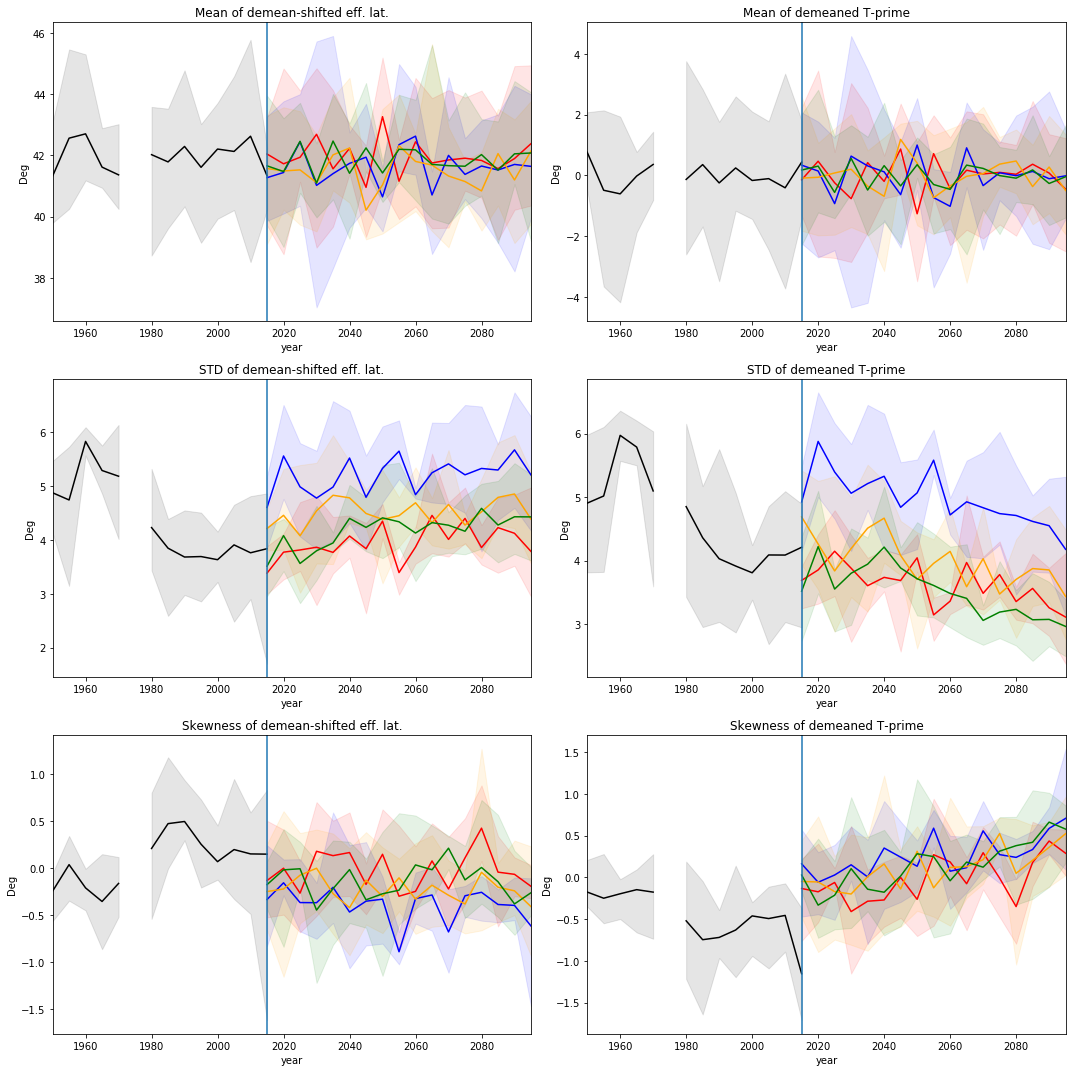

In [16]:
# Chicago: 42N, 87.5W
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(15,15))
phi_eff_plots('Chicago',ax1,ax3,ax5)
dm_t_prime_plots('Chicago',ax2,ax4,ax6)
fig.tight_layout()
plt.show()

## Slope Plots

In [5]:
#Reanalysis
# 50-79
def slope_reanalysis1(lonsel,latsel,city):
    print('closest value')
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1950_1979_t_prime_demeaned.nc4')
    given_value=latsel
    lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
    print(lat_closest_value)
    given_value=lonsel
    lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
    print(lon_closest_value)
    
    dataall=dataall.sel(lon=lon_closest_value)
    latlist=dataall.to_dataframe().reset_index().lat.unique()
    ind=np.where(latlist==lat_closest_value)[0][0]
    
    # read into the raw temperature datas
    dlist=[1950,1955,1960,1965,1970]
    def iswinter(month, day):
        return (month == 1) | (month == 2) | ((month == 12) & (day >= 15))
    for x in dlist:
        print(x)
        data=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/ds_1950_1979_lat_20_1D_rename/ds_1950_1979_lat_20_1D_rename_t_prime_'+str(x)+'-12-01_'+str(x+5)+'-03-01.nc4')
        select=data.sel(lon=lon_closest_value)
        select1=select.sel(lat=data.lat[ind])
        select2=select.sel(lat=data.lat[ind-1])
        select1=select1.sel(time=iswinter(select1['time.month'], select1['time.day']))
        select2=select2.sel(time=iswinter(select2['time.month'], select2['time.day']))
        # concat
        if x==1950:
            dataall1=select1
            dataall2=select2
        else:
            dataall1=xr.combine_by_coords([dataall1, select1])
            dataall2=xr.combine_by_coords([dataall2, select2])
    
    dataall1 = dataall1.to_dataframe().reset_index()
    dataall2 = dataall2.to_dataframe().reset_index()
    print('data loaded')
    
    # take slopes
    slall = dataall1[['time']]
    ent=(latlist[ind]-latlist[ind-1])/(dataall1['t_ref']-dataall2['t_ref'])
    slall['slope']=ent
    slall['year']=slall.time.dt.year
    slall['month']=slall.time.dt.month
    slall['winter']=slall['year']
    mask=slall.month<=3
    slall.loc[mask, 'winter'] = slall['year']-1
    slall['decade']=(np.floor((slall['winter']-1950)/5)+1)*5+1945
    slall.to_csv('/project2/moyer/jetstream/ribbon_files/slope_all_'+city+'_pre1.csv',index=True)
           
    # 1950-1979
    dlist=[1950,1955,1960,1965,1970]
    sldf=pd.DataFrame(columns = ['decade','mean','min','max'])
    for x in dlist:
        print(x)
        select=slall[year_separator(slall.time.dt.year,slall.time.dt.month,x,x+5)]
        slsum=select[['slope','decade']].groupby(['decade']).agg(['mean','min','max'])
        slsum.columns=slsum.columns.droplevel()
        sldf=sldf.append(slsum, sort=True)
    
    sldf.to_csv('/project2/moyer/jetstream/ribbon_files/slope_sum_'+city+'_pre1.csv',index=True)


In [ ]:
# Chicago
slope_reanalysis1(-87.5,42,'Chicago')

closest value
42.0
-87.5
1950


In [8]:
    latsel=42
    lonsel=-87.5
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1950_1979_t_prime_demeaned.nc4')
    given_value=latsel
    lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
    print(lat_closest_value)
    given_value=lonsel
    lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
    print(lon_closest_value)

MemoryError: Unable to allocate 6.76 GiB for an array with shape (2250, 280, 1440) and data type float64

In [66]:
#Reanalysis
# 79-20
def slope_reanalysis2(lonsel,latsel,city):
    print('closest value')
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1979_2021_t_prime_demeaned.nc4')
    given_value=latsel
    lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
    print(lat_closest_value)
    given_value=lonsel
    lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
    print(lon_closest_value)
    
    latlist=dataall.to_dataframe().reset_index().lat.unique()
    ind=np.where(latlist==lat_closest_value)[0][0]
    
    # read into the raw temperature datas
    x1list=[1979,1984,1986,1988]
    x2list=[1984,1986,1988,1990]
    def iswinter(month, day):
        return (month == 1) | (month == 2) | ((month == 12) & (day >= 15))
    for i in range(0,4):
        x1=x1list[i]
        x2=x2list[i]
        data=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/ds_1979_2021_lat_20_1D_renamed/ds_1979_2021_lat_20_1D_renamed_t_prime_'+str(x1)+'-12-01_'+str(x2)+'-03-01.nc4')
        select=data.sel(lon=lon_closest_value)
        select1=select.sel(lat=data.lat[ind])
        select2=select.sel(lat=data.lat[ind-1])
        select1=select1.sel(time=iswinter(select1['time.month'], select1['time.day']))
        select2=select2.sel(time=iswinter(select2['time.month'], select2['time.day']))
        # concat
        if x1==1979:
            dataall1=select1
            dataall2=select2
        else:
            dataall1=xr.combine_by_coords([dataall1, select1])
            dataall2=xr.combine_by_coords([dataall2, select2])
    
    for y in range(1990,2020):
        data=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/ds_1979_2021_lat_20_1D_renamed/ds_1979_2021_lat_20_1D_renamed_t_prime_'+str(y)+'-12-01_'+str(y+1)+'-03-01.nc4')
        select=data.sel(lon=lon_closest_value)
        select1=select.sel(lat=data.lat[ind])
        select2=select.sel(lat=data.lat[ind-1])
        select1=select1.sel(time=iswinter(select1['time.month'], select1['time.day']))
        select2=select2.sel(time=iswinter(select2['time.month'], select2['time.day']))
        # concat
        dataall1=xr.combine_by_coords([dataall1, select1])
        dataall2=xr.combine_by_coords([dataall2, select2])
    
    dataall1 = dataall1.to_dataframe().reset_index()
    dataall2 = dataall2.to_dataframe().reset_index()
    print('data loaded')
        
    # take slopes
    slall = dataall1[['time']]
    ent=(latlist[ind]-latlist[ind-1])/(dataall1['t_ref']-dataall2['t_ref'])
    slall['slope']=ent
    slall['year']=slall.time.dt.year
    slall['month']=slall.time.dt.month
    slall['winter']=slall['year']
    mask=slall.month<=3
    slall.loc[mask, 'winter'] = slall['year']-1
    slall['decade']=(np.floor((slall['winter']-1980)/5)+1)*5+1975
    slall.to_csv('/project2/moyer/jetstream/ribbon_files/slope_all_'+city+'_pre2.csv',index=True)

    # 1979-2021
    dlist=[1980,1985,1990,1995,2000,2005,2010,2015]
    sldf=pd.DataFrame(columns = ['decade','mean','min','max'])
    for x in dlist:
        print(x)
        select=slall[year_separator(slall.time.dt.year,slall.time.dt.month,x,x+5)]
        slsum=select[['slope','decade']].groupby(['decade']).agg(['mean','min','max'])
        slsum.columns=slsum.columns.droplevel()
        sldf=sldf.append(slsum, sort=True)
    
    sldf.to_csv('/project2/moyer/jetstream/ribbon_files/slope_sum_'+city+'_pre2.csv',index=True)
    

In [3]:
latsel=41
lonsel=-87
dataall=data
print('closest value')
absolute_difference_function = lambda list_value : abs(list_value - given_value)
given_value=latsel
lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
print(lat_closest_value)
given_value=lonsel
lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
print(lon_closest_value)

closest value
41.0
-87.0


In [4]:
latlist=dataall.to_dataframe().reset_index().lat.unique()
ind=np.where(latlist==lat_closest_value)[0][0]

In [5]:
latlist[ind]

41.0

In [32]:
select=data.sel(lon=lon_closest_value)
select1=select.sel(lat=data.lat[ind])
select2=select.sel(lat=data.lat[ind-1])
select1 = select1.sel(time=iswinter(select['time.month'], select['time.day']))
select2 = select2.sel(time=iswinter(select['time.month'], select['time.day']))

In [33]:
dataall1=select1
dataall2=select2

In [34]:
dataall1 = dataall1.to_dataframe().reset_index()
dataall2 = dataall2.to_dataframe().reset_index()

In [35]:
dataall1

,time,lat,lon,t_ref,t2m,t_prime
0,1950-12-15,41.0,-87.0,280.967974,268.987366,-11.980608
1,1950-12-16,41.0,-87.0,280.432659,263.348267,-17.084392
2,1950-12-17,41.0,-87.0,280.535757,260.472839,-20.062918
3,1950-12-18,41.0,-87.0,280.617118,256.481781,-24.135337
4,1950-12-19,41.0,-87.0,280.495161,259.526642,-20.968519
...,...,...,...,...,...,...
376,1955-02-24,41.0,-87.0,281.421778,275.178375,-6.243403
377,1955-02-25,41.0,-87.0,281.482596,272.465881,-9.016715
378,1955-02-26,41.0,-87.0,281.537935,279.844879,-1.693056
379,1955-02-27,41.0,-87.0,281.313685,281.137177,-0.176509


In [36]:
dataall2

,time,lat,lon,t_ref,t2m,t_prime
0,1950-12-15,41.25,-87.0,280.682446,269.005035,-11.677411
1,1950-12-16,41.25,-87.0,280.183820,263.353088,-16.830731
2,1950-12-17,41.25,-87.0,280.307527,261.860382,-18.447145
3,1950-12-18,41.25,-87.0,280.409046,259.759521,-20.649524
4,1950-12-19,41.25,-87.0,280.261020,259.891693,-20.369327
...,...,...,...,...,...,...
376,1955-02-24,41.25,-87.0,281.184695,275.081818,-6.102877
377,1955-02-25,41.25,-87.0,281.264364,272.160187,-9.104178
378,1955-02-26,41.25,-87.0,281.261620,279.443756,-1.817864
379,1955-02-27,41.25,-87.0,281.053153,280.238129,-0.815025


In [37]:
sldf = dataall1[['time']]
ent=(latlist[ind]-latlist[ind-1])/(dataall1['t_ref']-dataall2['t_ref'])
sldf['slope']=ent

/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
sldf

,time,slope
0,1950-12-15,-0.875572
1,1950-12-16,-1.004665
2,1950-12-17,-1.095383
3,1950-12-18,-1.201508
4,1950-12-19,-1.067733
...,...,...
376,1955-02-24,-1.054482
377,1955-02-25,-1.145573
378,1955-02-26,-0.904762
379,1955-02-27,-0.959576


In [40]:
dataall2

,time,lat,lon,t_ref,t2m,t_prime
0,1950-12-01,41.25,0.0,284.255066,284.255066,0.000000
1,1950-12-02,41.25,0.0,286.171295,286.171295,0.000000
2,1950-12-03,41.25,0.0,287.318665,287.318665,0.000000
3,1950-12-04,41.25,0.0,280.933777,280.933777,0.000000
4,1950-12-05,41.25,0.0,276.122131,276.122131,0.000000
...,...,...,...,...,...,...
446,1955-02-24,41.25,0.0,281.184695,283.939545,2.754850
447,1955-02-25,41.25,0.0,281.264364,282.754578,1.490213
448,1955-02-26,41.25,0.0,281.261620,280.070770,-1.190850
449,1955-02-27,41.25,0.0,281.053153,280.312012,-0.741142


In [52]:
select1=data.sel(lon=70)
select1=select1.sel(lat=41)
select2=data.sel(lon=20)
select2=select2.sel(lat=41)

In [53]:
select1

<xarray.Dataset>
Dimensions:  (time: 451)
Coordinates:
  * time     (time) datetime64[ns] 1950-12-01 1950-12-02 ... 1955-02-28
    lat      float32 41.0
    lon      float32 70.0
Data variables:
    t_ref    (time) float64 280.1 281.7 284.8 283.3 ... 281.5 281.5 281.3 280.9
    t2m      (time) float32 280.0955 281.6907 284.7526 ... 287.9505 291.61365
    t_prime  (time) float64 0.0 0.0 0.0 0.0 0.0 ... -0.7066 2.924 6.637 10.75

In [54]:
select2

<xarray.Dataset>
Dimensions:  (time: 451)
Coordinates:
  * time     (time) datetime64[ns] 1950-12-01 1950-12-02 ... 1955-02-28
    lat      float32 41.0
    lon      float32 20.0
Data variables:
    t_ref    (time) float64 285.4 286.8 287.4 287.8 ... 281.5 281.5 281.3 280.9
    t2m      (time) float32 285.40863 286.78018 287.35593 ... 285.71088 287.354
    t_prime  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 8.766 6.232 4.397 6.492

In [2]:
data=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/ds_1950_1979_lat_20_1D_rename/ds_1950_1979_lat_20_1D_rename_t_prime_1950-12-01_1955-03-01.nc4')
        

In [43]:
select1=data.sel(lon=70)
select1=select1.sel(lat=41)
select2=data.sel(lon=20)
select2=select2.sel(lat=41)

In [44]:
select1 = select1.sel(time=iswinter(select1['time.month'], select1['time.day']))
select2 = select2.sel(time=iswinter(select2['time.month'], select2['time.day']))

In [47]:
select1

<xarray.Dataset>
Dimensions:  (time: 381)
Coordinates:
  * time     (time) datetime64[ns] 1950-12-15 1950-12-16 ... 1955-02-28
    lat      float32 41.0
    lon      float32 70.0
Data variables:
    t_ref    (time) float64 281.0 280.4 280.5 280.6 ... 281.5 281.5 281.3 280.9
    t2m      (time) float32 279.30093 279.19168 278.06436 ... 287.9505 291.61365
    t_prime  (time) float64 -1.667 -1.241 -2.471 -3.386 ... 2.924 6.637 10.75

In [48]:
select2

<xarray.Dataset>
Dimensions:  (time: 381)
Coordinates:
  * time     (time) datetime64[ns] 1950-12-15 1950-12-16 ... 1955-02-28
    lat      float32 41.0
    lon      float32 20.0
Data variables:
    t_ref    (time) float64 281.0 280.4 280.5 280.6 ... 281.5 281.5 281.3 280.9
    t2m      (time) float32 287.06827 285.9714 286.7587 ... 285.71088 287.354
    t_prime  (time) float64 6.1 5.539 6.223 4.328 ... 8.766 6.232 4.397 6.492